In [1]:
# Importing libraries.
import pandas as pd
from gensim.models import KeyedVectors
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
embeddings_swow = KeyedVectors.load_word2vec_format('embeddings_google/SWOW_EN.r123.k400.vec', limit=None)

In [3]:
embeddings_fasttext = KeyedVectors.load_word2vec_format('embeddings_google/fasttext_common_crawl.vec', limit=None)

In [6]:
def glove_to_word2vec(glove_input_file_path, word2vec_output_file_path):
    with open(glove_input_file_path, 'r', encoding='utf-8') as glove_file:
        lines = glove_file.readlines()

    with open(word2vec_output_file_path, 'w', encoding='utf-8') as word2vec_file:
        # La primera línea en un archivo word2vec es el número de tokens y la dimensionalidad
        num_lines = len(lines)
        dimensions = len(lines[0].split()) - 1
        word2vec_file.write(f"{num_lines} {dimensions}\n")
        for line in lines:
            word2vec_file.write(line)

glove_input_file_path = 'embeddings_google/glove.42B.300d.txt'
word2vec_output_file_path = 'embeddings_google/glove.42B.300d.vec'

glove_to_word2vec(glove_input_file_path, word2vec_output_file_path)


In [7]:
embeddings_glove = KeyedVectors.load_word2vec_format('embeddings_google/glove.42B.300d.vec', binary=False)

In [8]:
embeddings_google = KeyedVectors.load_word2vec_format('embeddings_google\GoogleNews-vectors-negative300.bin.gz', binary=True)

In [9]:
embeddings_list = [embeddings_swow, embeddings_fasttext, embeddings_glove, embeddings_google]

In [10]:
def load_and_process_google_analogy_dataset(filepath):
    data = []

    with open(filepath, 'r') as file:
        for line in file:
            line = line.strip()
            if line.startswith(":"):
                category = line.strip(": ").replace(" ", "_")
            else:
                parts = line.split()
                if len(parts) == 4:
                    data.append([parts[0], parts[1], parts[2], parts[3]])

    analogies_df = pd.DataFrame(data, columns=['cueExample', 'targetExample', 'cue', 'response'])

    return analogies_df

filepath = 'google_test_set.csv'

analogies_df = load_and_process_google_analogy_dataset(filepath)

analogies_df['cueExample'] = analogies_df['cueExample'].apply(lambda x: str(x).lower().replace('"', ''))
analogies_df['targetExample'] = analogies_df['targetExample'].apply(lambda x: str(x).lower().replace('"', ''))
analogies_df['cue'] = analogies_df['cue'].apply(lambda x: str(x).lower().replace('"', ''))
analogies_df['response'] = analogies_df['response'].apply(lambda x: str(x).lower().replace('"', ''))

analogies_df['count'] = analogies_df.groupby(['cue', 'response'])['response'].transform('count')
analogies_df['rank'] = analogies_df.groupby('cue')['count'].rank(ascending=False, method='min')

total_responses = analogies_df.groupby('cue')['response'].transform('count')
analogies_df['percentage'] = (analogies_df['count'] / total_responses) * 100

idx = analogies_df.groupby(['cue'])['rank'].idxmin()

analogies_google_df = analogies_df.loc[idx]

analogies_google_df.to_csv('analogies_google_answers.csv', index=False)

print(analogies_google_df)

      cueExample targetExample         cue      response  count  rank   
3547      niamey         niger       abuja       nigeria     39   1.0  \
9916       aware       unaware  acceptable  unacceptable     28   1.0   
506        abuja       nigeria       accra         ghana     39   1.0   
6791       omaha      nebraska       akron          ohio     36   1.0   
14299  australia    australian     albania      albanian     39   1.0   
...          ...           ...         ...           ...    ...   ...   
13158       code        coding       write       writing     32   1.0   
15820    dancing        danced     writing         wrote     39   1.0   
3469     nairobi         kenya     yerevan       armenia     39   1.0   
10708        bad         worse       young       younger     36   1.0   
3508      nassau       bahamas      zagreb       croatia     39   1.0   

       percentage  
3547   100.000000  
9916   100.000000  
506    100.000000  
6791   100.000000  
14299  100.000000  
...

In [11]:
not_found_words = [] 

def calculate_predictions(embedding, analogies_google_df, K):
    predictions = [] 
    for index, row in analogies_google_df.iterrows():  
        cueExample = row['cueExample']
        targetExample = row['targetExample']  
        cue = row['cue']

        try:
            result = embedding.most_similar(positive=[cueExample, targetExample, cue], topn=K)
            predictions.append([word for word, _ in result])
        except KeyError as e:  
            print(f"Una de las palabras no está en el embedding: {e}")  
            predictions.append([])  
            not_found_words.append(str(e).split("'")[1])  
    return predictions  

def topK_metrics(predictions, analogies_google_df, K):
    analogies_google_df['response'] = analogies_google_df['response'].fillna('')  
    analogies_google_df['response'] = analogies_google_df['response'].apply(lambda x: str(x)) 
    topK_metrics = []  
    for i, prediction in enumerate(predictions): 
        human_response = analogies_google_df.iloc[i]['response'].lower()  
        topK_metrics.append(int(human_response in prediction[0:K]))
    return np.mean(topK_metrics)

K = 5
all_predictions = [calculate_predictions(e, analogies_google_df, K) for e in embeddings_list]
topK_metrics = [topK_metrics(prediction, analogies_google_df, K) for prediction in all_predictions]
print(f"Top-K metrics for K={K}: {topK_metrics}")

Una de las palabras no está en el embedding: "Key 'niamey' not present in vocabulary"
Una de las palabras no está en el embedding: "Key 'abuja' not present in vocabulary"
Una de las palabras no está en el embedding: "Key 'omaha' not present in vocabulary"
Una de las palabras no está en el embedding: "Key 'australia' not present in vocabulary"
Una de las palabras no está en el embedding: "Key 'angola' not present in vocabulary"
Una de las palabras no está en el embedding: "Key 'abuja' not present in vocabulary"
Una de las palabras no está en el embedding: "Key 'miami' not present in vocabulary"
Una de las palabras no está en el embedding: "Key 'apparently' not present in vocabulary"
Una de las palabras no está en el embedding: "Key 'abuja' not present in vocabulary"
Una de las palabras no está en el embedding: "Key 'chicago' not present in vocabulary"
Una de las palabras no está en el embedding: "Key 'chicago' not present in vocabulary"
Una de las palabras no está en el embedding: "Key 

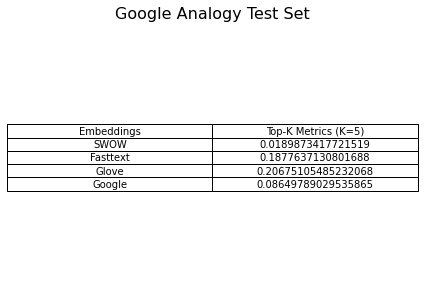

In [17]:
metrics = [0.0189873417721519, 0.1877637130801688, 0.20675105485232068, 0.08649789029535865]
embeddings_names = ["SWOW", "Fasttext", "Glove", "Google"]

# df
df = pd.DataFrame({
    "Embeddings": embeddings_names,
    "Top-K Metrics (K=5)": metrics
})

fig, ax = plt.subplots()
ax.axis('tight')
ax.axis('off')

# crear la tabla
table = ax.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center')
fig.suptitle('Google Analogy Test Set', fontsize=16)
fig.tight_layout()

# guardar como imagen
plt.savefig('table.png', dpi=300)